In [2]:
import kagglehub
import sys
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn

In [3]:
path = kagglehub.dataset_download("talhasar/genki4k")
print("Path to dataset files:", path)

100%|██████████| 25.0M/25.0M [00:00<00:00, 145MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/talhasar/genki4k/versions/1


In [4]:
! git clone https://github.com/kia-vadaei/Smile-Detection.git

Cloning into 'Smile-Detection'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 56 (delta 2), reused 0 (delta 0), pack-reused 44 (from 1)
Receiving objects: 100% (56/56), 79.37 MiB | 11.60 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (9/9), done.


In [5]:
module_path = './Smile-Detection/src'
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
! pip install -q -r Smile-Detection/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.9 MB/s eta 0:00:00


In [7]:
from Preprocessing import Preprocessing

In [8]:
%mkdir ./dataset

In [9]:
preprocessing = Preprocessing(output_smile = './dataset/smile',
                              output_non_smile = './dataset/non_smile',
                              input_main_path = '/root/.cache/kagglehub/datasets/talhasar/genki4k/versions/1/kaggle-genki4k')

preprocessing.run_on_dataset()

non-smile class is being preprocessed: 100%|██████████| 1838/1838 [03:57<00:00,  7.75it/s]


In [10]:
from SmileNonSmile import SmileNonSmileDataset, SmileDetectionCNN

In [16]:
data_dir = './dataset'
# torch.manual_seed(0)
dataset = SmileNonSmileDataset(data_dir=data_dir,)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size],)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
model = SmileDetectionCNN().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
num_epochs = 25
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    val_running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss_history.append(running_loss)


    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    model.eval()
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = inputs.to('cuda'), labels.to('cuda')
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += loss.item()
        val_loss_history.append(val_running_loss)


Epoch 1/25, Loss: 0.7007595122508381
Epoch 2/25, Loss: 0.47719896260810934
Epoch 3/25, Loss: 0.34137036230253137
Epoch 4/25, Loss: 0.2780143287356781
Epoch 5/25, Loss: 0.23034380675981875
Epoch 6/25, Loss: 0.21193129063138497
Epoch 7/25, Loss: 0.16800689563641083
Epoch 8/25, Loss: 0.1298423727326419
Epoch 9/25, Loss: 0.0932183075271061
Epoch 10/25, Loss: 0.07210933870089281
Epoch 11/25, Loss: 0.042149868712801
Epoch 12/25, Loss: 0.03192867275388182
Epoch 13/25, Loss: 0.02754164202918258
Epoch 14/25, Loss: 0.03791356956429334
Epoch 15/25, Loss: 0.023195717068712995
Epoch 16/25, Loss: 0.051395202865735526
Epoch 17/25, Loss: 0.024261716155350492
Epoch 18/25, Loss: 0.009982918261654128
Epoch 19/25, Loss: 0.0033566654894220055
Epoch 20/25, Loss: 0.0017418302752206648
Epoch 21/25, Loss: 0.0014911815000548654
Epoch 22/25, Loss: 0.0011356790847141542
Epoch 23/25, Loss: 0.0009241387235859926
Epoch 24/25, Loss: 0.000747086040993726
Epoch 25/25, Loss: 0.0006238760924549316


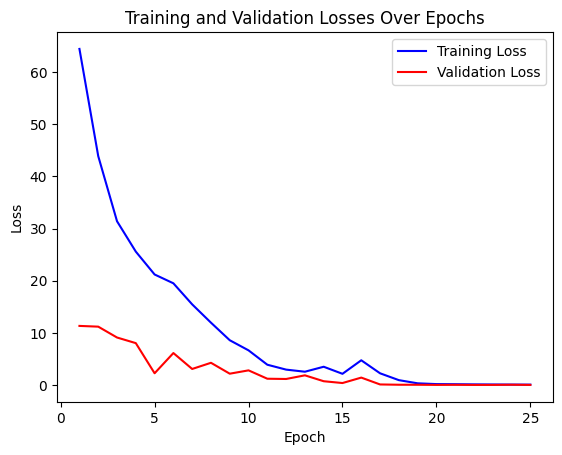

In [19]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_loss_history, label="Training Loss", color='blue')
plt.plot(epochs, val_loss_history, label="Validation Loss", color='red')

plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.show()

In [20]:
import torch
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader

model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the predicted class with the highest score

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])  # Replace with actual class names if needed
print(report)


              precision    recall  f1-score   support

     Class 0       0.88      0.88      0.88       416
     Class 1       0.84      0.84      0.84       321

    accuracy                           0.86       737
   macro avg       0.86      0.86      0.86       737
weighted avg       0.86      0.86      0.86       737



In [21]:
torch.save(model.state_dict(), './model.pth')